# HW5: Convolutional Neural Nets, Object Classification & Detection

Using convolutional nets for classification and detection is a very simple process these days with recent deep NN frameworks APIs, and is the standard practice in computer vision engineering practice. Conv nets have been shown to be far superior in such visual understanding tasks.

This time we will take a canonical, basic, but maybe not very easy, classification task: Cats vs. Dogs.

We will start from standard classification with a NN, and work our way to detection through "transfer learning". On the way we will also interrogate our network to visualiaze "what do the neurons like?", which is a good way to verify our network actually learns what we think it learns (rather than overfitting on noise or outliers).

Classification conv NNs are so versatile, they have been used in virtually any setting and visual data: natural photos, smartphones, heavy industry, medical, aerial, defense, entertainment, automotive, and just about any other computer vision domain out there. Recently, deep conv nets are also used for *audio* signal processing and *text* processing... so it's a very good skill to practice that will serve you well!

As mentioned in class we're using [Keras](keras.io]) on top of [Tensorflow](tensorflow.org), however many people prefer [PyTorch](https://pytorch.org/) for it's eager execution and simple API. I find that Keras gives PyTorch a run for it's money in all regards, and especially because it's partenred with Tensorflow - today's most widely used deep learning framework.

In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import patches
import tensorflow as tf
import IPython.display
import requests
import io
import zipfile
import sys
import json
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20,5)

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Input, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras import backend as K

#### A tool for visualizing conv-nets

In [2]:
!git clone https://github.com/royshil/convnet-drawer.git && mv convnet-drawer convnet_drawer

fatal: destination path 'convnet-drawer' already exists and is not an empty directory.


In [3]:
from convnet_drawer import convnet_drawer, keras_util

Using TensorFlow backend.


In [4]:
CLASSIFY_BATCH_SIZE = 32

## Reading the image data efficiently

We would like our model training to be efficient. So while (hopefully) the GPU is doing the learning on a batch of input data we can utilize the CPU to preprocess more data in the background

This is best done, in Tensorflow environment, using the `tf.Dataset` API (https://www.tensorflow.org/guide/datasets). We can chain many preprocessing oprations together, e.g.: (1) Read the JPEG, (2) Rescale from [0,255]->[0,1], (3) Resize to [150,150] (that's the input shape to our deep network), ... and so on.

Below is a function that takes in the files in a directory and returns a `tf.Dataset` which we can use for training or testing.

In [5]:
def make_dataset_for_directory(directory, batch_size, augment=True, shuffle=True, take_subset=-1):
    dogs_train = sorted(glob.glob('%s/dogs/*.jpg'%directory))
    cats_train = sorted(glob.glob('%s/cats/*.jpg'%directory))

    filenames = dogs_train + cats_train
    labels = [[1,0]] * len(dogs_train) + [[0,1]] * len(cats_train)    
    if take_subset < 0:
        take_subset = len(labels)
        
    print("Found %d images in '%s'"%(len(filenames), directory))

    # Reads an image from a file, decodes it into a dense tensor, and resizes it
    # to a fixed shape, range [0,1]
    def decode_image_file(filename, y):
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string)
        return tf.cast(image_decoded, tf.float32) / 255.0, y
    
    def resize_image(x, y):
        return tf.image.resize_image_with_pad(x, 150, 150), y

    def color_aug(x: tf.Tensor) -> tf.Tensor:
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
        return x
    
    def flip_aug(x: tf.Tensor) -> tf.Tensor:
        x = tf.image.random_flip_left_right(x)
        return x
    
    def zoom_aug(x: tf.Tensor) -> tf.Tensor:
        shape = tf.cast(tf.shape(x),tf.float32)
        return tf.image.random_crop(x, [shape[0]*0.8, shape[1]*0.8, 3])
    
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(filenames[:take_subset]), tf.constant(labels[:take_subset])))
    dataset = dataset.map(decode_image_file, num_parallel_calls=4)
    
    AUGMENT_REPEATS = 4
    
    if augment:
        print("Augmenting. Total number of samples: %d"%(len(labels) * AUGMENT_REPEATS))
        
        dataset = dataset.repeat(AUGMENT_REPEATS) # add 4 repeats per image, for augmentations
        
        # Add augmentations
        augmentations = [flip_aug, color_aug, zoom_aug]

        # Add the augmentations to the dataset
        for f in augmentations:
            # Apply the augmentation, run 4 jobs in parallel.
            dataset = dataset.map(lambda x, y: (tf.cond(tf.random_uniform([], 0, 1) > 0.5, lambda: f(x), lambda: x), y), num_parallel_calls=4)

    dataset = dataset.map(resize_image, num_parallel_calls=4)
    
    # clip and normalize to [-1,1] range
    dataset = dataset.map(lambda x, y: (tf.clip_by_value(x, 0, 1) * 2.0 - 1.0, y), num_parallel_calls=4)

    # All the dogs are at the beginning and the cats in the end.... 
    # This way our model will first just learn to predict all 0s! We must shuffle the samples!
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels) * (AUGMENT_REPEATS if augment else 1), seed=42)
    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
        
    return dataset

### Download Dataset
This may take ~1 minute to complete.

In [6]:
dl_url = 'https://storage.googleapis.com/cse527-spring19/catsdogs.zip'
zipf = zipfile.ZipFile(io.BytesIO(requests.get(dl_url).content))
zipf.extractall('.')
zipf.close()

## Data Augmentation
 
One way of regularization and batteling overfitting, especially in a small dataset, is to "augment" our available input data. Working with images this might be adding: changes in brightness / hue, random cropping, random flipping. This can add many more examples for training and better generalize over the distribution we may see in validation.

### Without augmentation


In [7]:
non_augmented_dataset = make_dataset_for_directory('catsdogs/test_set/', CLASSIFY_BATCH_SIZE, shuffle=False, augment=False, take_subset=8)

Found 2000 images in 'catsdogs/test_set/'
Instructions for updating:
Colocations handled automatically by placer.


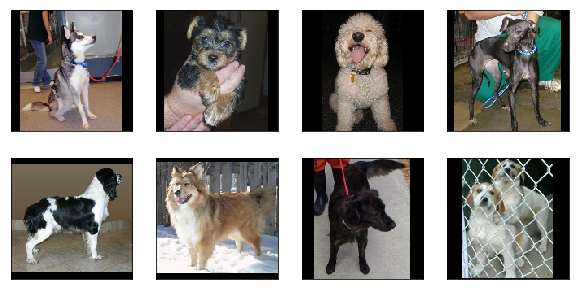

In [8]:
it = non_augmented_dataset.make_one_shot_iterator()
x, y = K.get_session().run(it.get_next())
plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow((x[i] + 1.0) / 2.0)
    plt.xticks([]),plt.yticks([])

### With Augmentation
This time we will see the same 8 images repeated 4 times with changes to the image in each iteration.

In [9]:
augmented_dataset = make_dataset_for_directory('catsdogs/test_set/', CLASSIFY_BATCH_SIZE, shuffle=False, take_subset=8)

Found 2000 images in 'catsdogs/test_set/'
Augmenting. Total number of samples: 8000


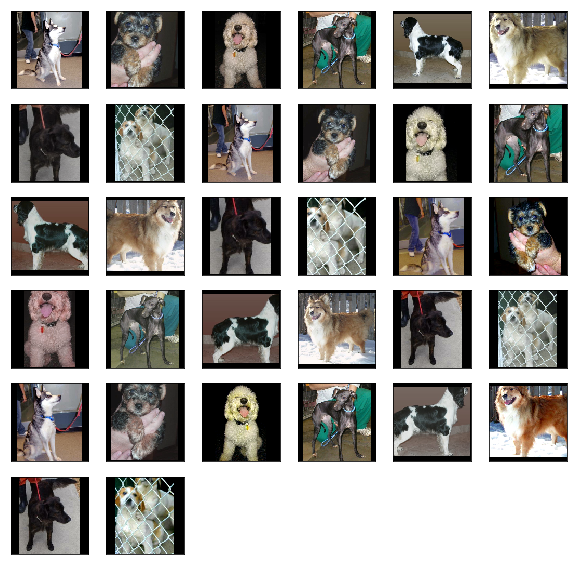

In [10]:
it = augmented_dataset.make_one_shot_iterator()
x, y = K.get_session().run(it.get_next())
plt.figure(figsize=(10,10))
for i in range(CLASSIFY_BATCH_SIZE):
    plt.subplot(6,6,i+1)
    plt.imshow((x[i] + 1.0) / 2.0)
    plt.xticks([]),plt.yticks([])

---
## Convolutions


Define the simplest convolutional model, with just a single "layer" that has just a single convolution, without activation (e.g. "linear").

In [11]:
inputs = Input(shape=(150,150,3))
conv_layer = Conv2D(1, (3,3), activation='linear', padding='same')(inputs)
model = Model(inputs, conv_layer)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 1)       28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [13]:
keras_util.convert_drawer_model(model).save_fig("test.svg")
IPython.display.display(IPython.display.HTML(open('test.svg').read()))

There are 28 parameters: 27 for the $3\times3$ kernel $\times3$ channels + 1 bias.

Here we set the convolution filter to be a "box filter" - all 1s.

In [14]:
model.layers[1].set_weights([np.expand_dims(np.array([[[1,1,1],[1,1,1],[1,1,1]],
                                                     [[1,1,1],[1,1,1],[1,1,1]],
                                                     [[1,1,1],[1,1,1],[1,1,1]]]),axis=-1),np.array([1])])

The result is, as expected, a blurred version of the input.

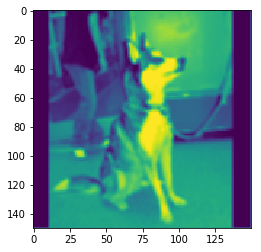

In [15]:
plt.imshow(model.predict(np.expand_dims(x[0], axis=0))[0,:,:,0]);

By setting a bigger stride we can reduce spatial resolution. The `padding` setting can be set to 'same' for 0-padding so the output has the same resolution (given a stride of 1), while 'valid' will not apply any padding and therefore will reduce the resolution by 1 pixel from each side (in a 3x3 convolution).

In [16]:
conv_layer = Conv2D(1, (3,3), activation='linear', padding='valid', strides=(2, 2))(inputs)
model = Model(inputs, conv_layer)

Let's try some different filters for the R,G,B channels

In [17]:
model.layers[1].set_weights([np.expand_dims(np.array([[[-1,0,1],[-2,0,2],[-1,0,1]],
                                                     [[-1,-1,-1],[0,0,0],[1,1,1]],
                                                     [[0,1,0],[1,4,1],[0,1,0]]]),axis=-1),np.array([1])])

In [18]:
keras_util.convert_drawer_model(model).save_fig("test.svg")
IPython.display.display(IPython.display.HTML(open('test.svg').read()))

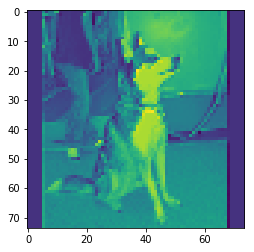

In [19]:
plt.imshow(model.predict(np.expand_dims(x[0], axis=0))[0,:,:,0]);

----
# Here comes your part

Complete all the code parts that need your attention. 

You have example results from my implementation however don't expect to get precisely the same results as there's often randomness in the process. As long as your results achieve the goal with reasonable accuracy, and follow the instruction - you will get full marks.

## Classification
Let's define a simple convolutional model to handle our cats vs. dogs binary classification problem.

In [20]:
tf.keras.backend.clear_session()

In [21]:
def make_classification_model():
    inputs = Input(shape=(150, 150, 3))

    # Following the standard conv-pool scheme we construct a convolutional layer
    x = Conv2D(32, (5, 5), padding='same', activation='relu', name='conv1')(inputs)
    # And following up with a (2,2) Max-Pool
    x = MaxPool2D()(x)
    # Batch normalization is a regularization tool (keeps output normalized e.g. [-1,1])
    x = BatchNormalization()(x)

    # We do this a few times, each time increasing the number of filters while reducing 
    # in spatial resolution:
   
    # TODO: add similar conv-pool-BN layers pattern to match the architecture below
    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2')(x)
    # And following up with a (2,2) Max-Pool
    x = MaxPool2D()(x)
    # Batch normalization is a regularization tool (keeps output normalized e.g. [-1,1])
    x = BatchNormalization()(x)
    
    # TODO: add similar conv-pool-BN layers pattern to match the architecture below
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3')(x)
    # And following up with a (2,2) Max-Pool
    x = MaxPool2D()(x)
    # Batch normalization is a regularization tool (keeps output normalized e.g. [-1,1])
    x = BatchNormalization()(x)
    
    # TODO: add similar conv-pool-BN layers pattern to match the architecture below
    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv4')(x)
    # And following up with a (2,2) Max-Pool
    x = MaxPool2D()(x)
    # Batch normalization is a regularization tool (keeps output normalized e.g. [-1,1])
    x = BatchNormalization()(x)
    
    # TODO: add similar conv-pool-BN layers pattern to match the architecture below
    x = Conv2D(192, (3, 3), padding='same', activation='relu', name='conv5')(x)
    # And following up with a (2,2) Max-Pool
    x = MaxPool2D()(x)
    # Batch normalization is a regularization tool (keeps output normalized e.g. [-1,1])
    x = BatchNormalization()(x)



    # Taking an average pool over the filter domain. The output will be 192, flattening the 
    # visual features to a long vector.
    x = GlobalAveragePooling2D()(x)

    # Finally we output a "binary" decision using two neurons with softmax activation (this is
    # done to help us in visualization, but for real classification we can use a single neuron
    # with 'sigmoid' activation)
    output = Dense(2, activation='softmax')(x)

    return Model(inputs=inputs, outputs=output)

In [22]:
model = make_classification_model()

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2 (Conv2D)               (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 37, 37, 64)        256       
__________

In [24]:
keras_util.convert_drawer_model(model).save_fig("test.svg")
IPython.display.display(IPython.display.HTML(open('test.svg').read()))

In [25]:
# TODO: compile your model with `adam` optimizer, `categorical_crossentropy` loss, and add an `accuracy` metric
# TODO: compile your model with `adam` optimizer, `categorical_crossentropy` loss, and add an `accuracy` metric
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
              metrics=['accuracy'])

In [26]:
checkpoint = ModelCheckpoint('cats_vs_dogs.best_weights.hdf5', 
                             monitor='val_acc', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='auto')

Read the directories with the data

In [27]:
cats_dogs_train_dataset = make_dataset_for_directory('catsdogs/training_set/', CLASSIFY_BATCH_SIZE, augment=False)
cats_dogs_valid_dataset = make_dataset_for_directory('catsdogs/test_set/', 50, augment=False)

Found 8000 images in 'catsdogs/training_set/'
Found 2000 images in 'catsdogs/test_set/'


Train the model

In [28]:
model.fit(cats_dogs_train_dataset, 
          epochs=30,
          steps_per_epoch=8000//32,
          validation_data=cats_dogs_valid_dataset,
          validation_steps=10,
          callbacks=[checkpoint, TensorBoard('./catsdogs-log'), EarlyStopping(patience=3)])

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
250/250 [==============================] - 480s 2s/step - loss: 0.6410 - acc: 0.6519 - val_loss: 1.1682 - val_acc: 0.4800
Epoch 2/30
250/250 [==============================] - 581s 2s/step - loss: 0.5395 - acc: 0.7312 - val_loss: 0.5868 - val_acc: 0.7200
Epoch 3/30
250/250 [==============================] - 474s 2s/step - loss: 0.4500 - acc: 0.7914 - val_loss: 0.9064 - val_acc: 0.6440
Epoch 4/30
250/250 [==============================] - 438s 2s/step - loss: 0.3629 - acc: 0.8391 - val_loss: 0.4590 - val_acc: 0.7840
Epoch 5/30
250/250 [==============================] - 441s 2s/step - loss: 0.3077 - acc: 0.8710 - val_loss: 0.3651 - val_acc: 0.8360
Epoch 6/30
250/250 [==============================] - 441s 2s/step - loss: 0.2380 - acc: 0.9010 - val_loss: 0.3332 - val_acc: 0.8440
Epoch 7/30
250/250 [==============================] - 441s 2s/step - loss: 0.1826 - acc: 0.9262 - val_loss: 0.3883 - val_acc: 0.8140
Epoch 8/30
250/250 [=

Early stopping ensures we don't overfit by training too much on the training set. Indeed we see the validation loss (and accuracy) are tracking along the training loss, until overfitting sets in and early stopping occurs. The checkpoint callback saved the best model weights to disk.

## Classification Inference

In [29]:
model.load_weights('cats_vs_dogs.best_weights.hdf5')

In [30]:
id_to_cls = lambda x: 'cat' if x == 1 else 'dog'

<span style="color:blue">Blue</span> means prediction was right (TP,TN), and <span style="color:red">Red</span> means prediction was wrong (FP,FN).

Found 2000 images in 'catsdogs/test_set/'


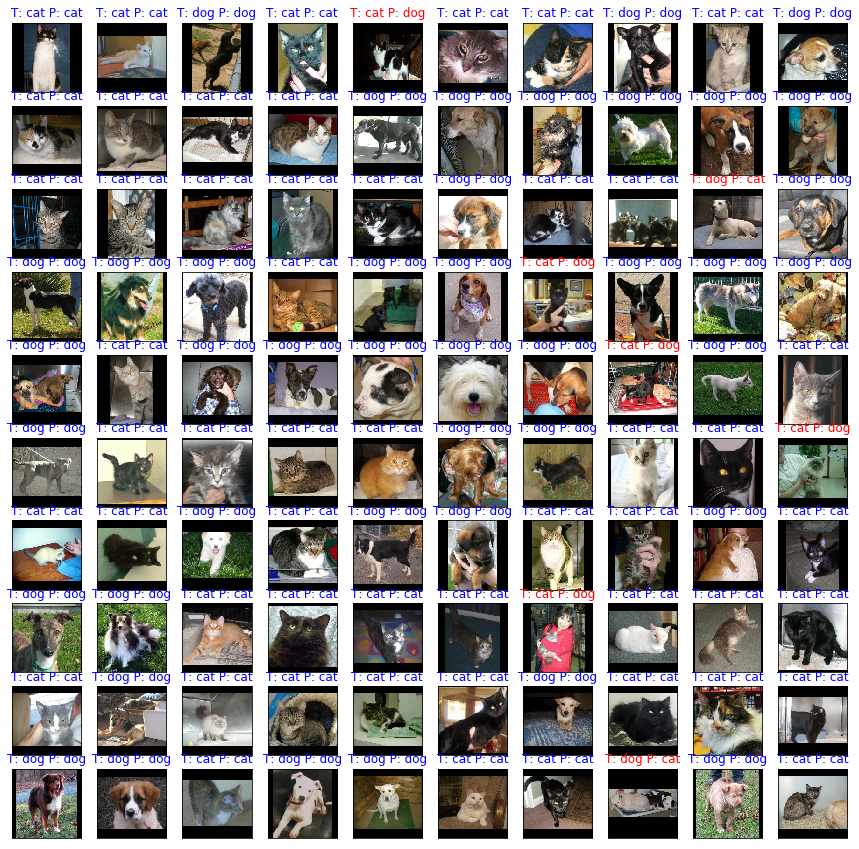

In [31]:
it = make_dataset_for_directory('catsdogs/test_set/', 1000, augment=False).make_one_shot_iterator()
x, y = tf.keras.backend.get_session().run(it.get_next())
y_pred = model.predict(x)
y_d = np.argmax(y, axis=1)
y_pred_d = np.argmax(y_pred, axis=1)

plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow((np.squeeze(x[i]) + 1.0) / 2.0)
    plt.title("T: %s P: %s"%(id_to_cls(y_d[i]),id_to_cls(y_pred_d[i])), color='b' if y_d[i] == y_pred_d[i] else 'r')
    plt.xticks([]),plt.yticks([])

### Analysis of Classifier

In [32]:
print("Accuracy:\t",  accuracy_score(y_d, y_pred_d))
print("Precision:\t", precision_score(y_d, y_pred_d))
print("Recall:\t\t",  recall_score(y_d, y_pred_d))
print("F1 score:\t",  f1_score(y_d, y_pred_d))

Accuracy:	 0.902
Precision:	 0.896484375
Recall:		 0.9107142857142857
F1 score:	 0.9035433070866141


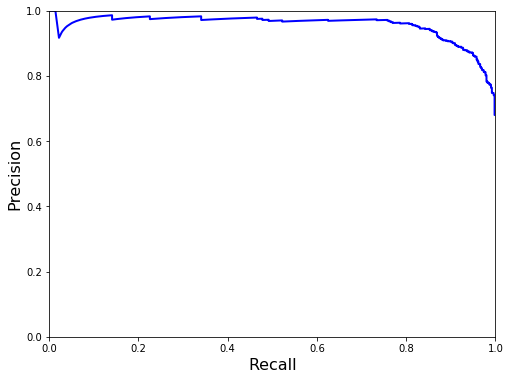

In [33]:
precisions, recalls, thresholds = precision_recall_curve(y[:,0], y_pred[:,0])
plt.figure(figsize=(8,6))
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.ylim(0,1), plt.xlim(0,1)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16);

I conclude this is a pretty decent classifier! Those cat-dog images are fairly unconstrained (high background variance, lighting, many breeds of dogs,...) , so the model must have learned pretty well the visual appearance of cats and dogs and what sets them apart...

How can we know what the model actually learned? Looking at the weights of the filters will not tell us much, and there are so many of them.

## Visualizing what the network learns

Here we will look at a few visualization techniques for convolutional layers that can helps us understand what the model had learned.

Let's load some data to work with:

In [34]:
it_one = make_dataset_for_directory('catsdogs/test_set/', 1, augment=False).make_one_shot_iterator()

Found 2000 images in 'catsdogs/test_set/'


In [35]:
x, y = K.get_session().run(it_one.get_next())

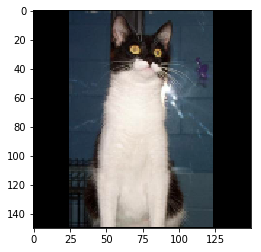

In [36]:
plt.imshow((x[0]+1.)/2.)

### Activation Maps

The simplest way of knowing what happens in the network is simply to look at the neural activation maps. A bright spot corresponds to a convolutional neuron firing strongly at its position given the input and the kernel.

In [37]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

We can "query" any part of the network with `K.function()` if we can get a pointer to the tensor (here we're using a dictionary to give us the `conv5` tensor). This is useful if we want to "feed forward" only a part of the network and not everything all the way to the end.

`K.function()` will take an input and an output, and feed forward through the network from input to output. In this case we feed in the dog image and output `conv5` layers activations (`.output`).

Try looking at different layers, e.g. `conv4` or `conv1` even.

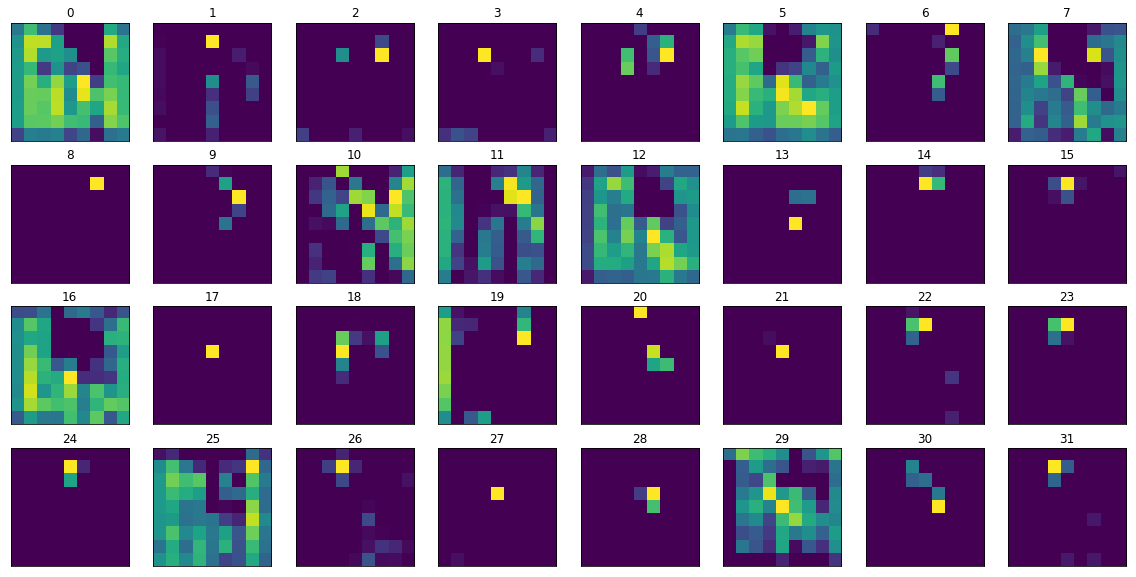

In [38]:
activation_maps, y_pred = K.function([model.inputs[0]], [layer_dict['conv5'].output, model.outputs])([x])
plt.figure(figsize=(20,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(activation_maps[0,:,:,i])
    plt.title("%d"%(i))
    plt.xticks([]),plt.yticks([])

### Class-weighted activation map (CAM)

The final "dense" layers is virtually a weighted sum of the output of the global average pooling of the final convolution activations (visualized above).

Each convolution is associated with a weight and those weights define the final classification decision.

So we can simply take a weighted average of the convolution activation maps w.r.t a single class (here, "dog" is index 0 and "cat" is index 1) and we have a "saliency map" - an activation map specific for the selected class.

In [39]:
activation_weights = model.layers[-1].get_weights()[0][:,1] # a bigger weights correlate with good "cat features"

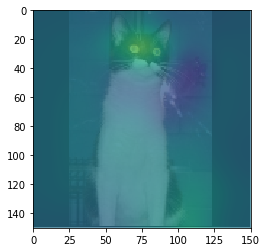

In [40]:
plt.imshow((x[0]+1.)/2.)
plt.imshow((activation_weights * activation_maps[0]).mean(axis=-1), 
           interpolation='bicubic', 
           alpha=0.75, 
           extent=(0,150,150,0))

We can see the "cat-liking" convolutions were able to localize the dog in the image.

Try it yourself:

In [41]:
# TODO: load an image from the iterator (e.g. x,_ = K.get_session().run()(... )
x,_=K.get_session().run(it_one.get_next())
# TODO: calculate the activation map (e.g. activation_maps = K.function(...)(x) ) 
activation_map= K.function([model.inputs[0]],[layer_dict['conv5'].output,model.outputs])([x])

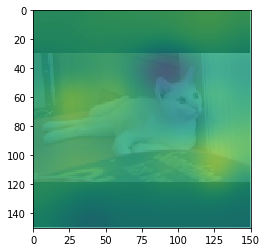

In [42]:
plt.imshow((x[0]+1.)/2.)
plt.imshow((activation_weights * activation_map[0][0]).mean(axis=-1), 
           interpolation='bicubic', 
           alpha=0.75, 
           extent=(0,150,150,0))

Out network certainly knows what it's doing!

### Visual features that activate a filter

One interesting method to visualize what particular filters (kernels) have learned is to find inputs that maximize their activation. 

How can we find such input? We can utilize gradient descent! 

Remember in GD we're minimizing the loss using the gradient, therefore, we can take our filter's output to be the "loss" - and bring that to it's maximum ("gradient **ascent**"), backpropagating all the way back to the input making small chages to it. We can start from completely random input, just to get some gradient going.

In [43]:
def normalize(x):
    """utility function to normalize a tensor by its Root Mean Square (RMS)."""
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

In [44]:
def visualize_filter(layer_name, filter_index, scale_factor=1.2, scale_steps=9):
    # the "loss" will simply be the average activation (mean of activation map) for that filter
    # if this number will be high, the filter neurons will be very happy and excited!
    loss = K.mean(layer_dict[layer_name].output[:, :, :, filter_index])
    
    # take the gradient of the loss w.r.t the input, this will tell us how to update the input
    # in order to increase the "loss"
    grads = normalize(K.gradients(loss, model.inputs[0])[0])
    
    # A K.function() takes as input an image and outputs the loss and gradients
    iterate = K.function([model.inputs[0]], [loss, grads])

    # make a small random image patch, as we will work in increasing spatial resolutions
    small_dim = int(150 / (scale_factor ** scale_steps))
    input_img_data = (np.random.random((1, small_dim, small_dim, 3)) - 0.5) * 2.0 # [-1,1]

    step = 0.01 # mock "learning rate", "weights" update step
    for up in reversed(range(scale_steps)):
        for _ in range(20):
            # one iteration of the gradient ascent
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step # update the "input" with the gradient

            # some filters get stuck to 0, we can skip them
            if loss_value <= K.epsilon():
                break
        
        up_dim = int(150 / (scale_factor ** up)) # we incrementally increase in size, to aid in convergence
        input_img_data = np.clip(np.expand_dims(cv2.resize(input_img_data[0], (up_dim, up_dim)), axis=0), -1, 1)
        
    return np.clip(input_img_data[0], -1, 1)

Select some features from 'conv5' layers. Notice some filters appear to be "dead" but that night just be because our "learning rate" is too big or too small.

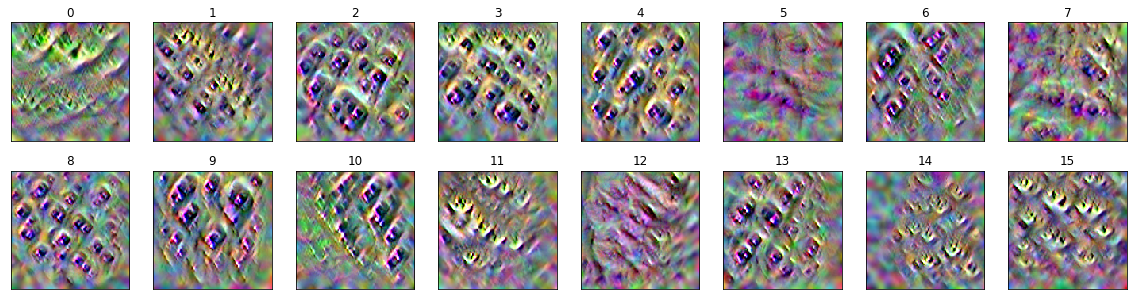

In [45]:
plt.figure(figsize=(20,5))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow((visualize_filter('conv5',i)+1.)/2.)
    plt.title("%d"%(i))
    plt.xticks([]),plt.yticks([])

Seems our network is learning what appears to be noses and eyes mostly... but remember these are just **16** filters out of 192!

## Object detection
We will implement a very simple region-proposal network (RPN) for just our two classes (cats and dogs), which follows the You Only Look Once (YOLO) scheme [[Redmon 2016]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf).

#### Download dataset

In [46]:
dl_url = 'https://storage.googleapis.com/cse527-spring19/catsdogs_detection.zip'
zipf = zipfile.ZipFile(io.BytesIO(requests.get(dl_url).content))
zipf.extractall('.')
zipf.close()

## Preparing the data for learning
This is a helper function we will need:

In [47]:
def batch_iou(a, b, epsilon=1e-5):
    """ Given two arrays `a` and `b` where each row contains a bounding
        box defined as a list of four numbers: [x1,y1,x2,y2]
        Returns the Intersect of Union scores for each corresponding
        pair of boxes.
    """
    x1 = np.array([a[:, 0], b[:, 0]]).max(axis=0)
    y1 = np.array([a[:, 1], b[:, 1]]).max(axis=0)
    x2 = np.array([a[:, 2], b[:, 2]]).min(axis=0)
    y2 = np.array([a[:, 3], b[:, 3]]).min(axis=0)

    # AREAS OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    width[width < 0] = 0
    height[height < 0] = 0

    area_overlap = width * height

    # COMBINED AREAS
    area_a = (a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1])
    area_b = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined + epsilon)
    return iou

#### Grid
We will be working in a $4\times4$ grid to match our classification model that ended with a $4\times4\times192$ tensor of visual features.

In YOLO and SSD there's a choice of box aspects in each grid cell, e.g. $1:1$, $1:2$, $2:1$, ..., however we will use a simpler approach of only $1:1$ aspect boxes of different sizes.

We construct a grid of bounding boxes $2\times2$, $3\times3$ and full $4\times4$ size in sliding window style:

In [48]:
bb_points_grid = np.dstack(np.meshgrid(np.linspace(0,150,5), np.linspace(0,150,5)))
bb_box_grid = []
for i in range(3):
    for j in range(3):
        bb_box_grid.append(np.hstack([bb_points_grid[i,j],bb_points_grid[i+2,j+2]]))
for i in range(2):
    for j in range(2):
        bb_box_grid.append(np.hstack([bb_points_grid[i,j],bb_points_grid[i+3,j+3]]))
bb_box_grid.append(np.hstack([bb_points_grid[0,0],bb_points_grid[-1,-1]]))

I'll do my best to visualize all the bounding boxes for you here, but keep in mind they are all overlapping! so it'd be hard to see each one.

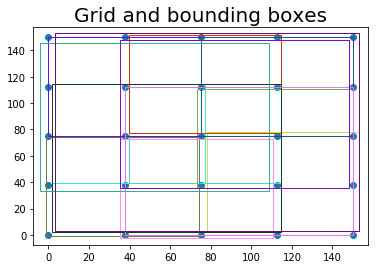

In [49]:
plt.scatter(bb_points_grid.reshape(-1,2)[:,0], bb_points_grid.reshape(-1,2)[:,1])
ax = plt.gca()
for i,bb in enumerate(bb_box_grid):
    r = np.random.randint(-4,4)
    c = np.hstack([np.random.random(3),1])
    rect = patches.Rectangle((bb[0]+r,bb[1]+r),bb[2]-bb[0],bb[3]-bb[1],edgecolor=c,facecolor='none')
    ax.add_patch(rect)
plt.title("Grid and bounding boxes", fontsize=20);

#### Reading the data
The dataset is a group of images with associated JSON files with the bounding box + class annotation.

We must rescale the images to $150\times150$ like the input to our classification net, with the same resize-with-pad trick so not to harm the aspect ratio of objects.

Thereafter we transform the bounding boxes with the same scaling and (possible) translation on either x- or y-axis.

We match the bounding boxes with each BBox in the grid, and if there's a match (IoU > 0.25) we find the offset (e.g. residual) from the grid-BBox to the true BBox, which is what we would like to find. We also note that grid-BBox has an object in it and which class it is.

In [50]:
from PIL import Image

def make_detection_dataset_for_directory(directory, batch_size, shuffle=True, take_subset=-1):
    images = sorted(glob.glob('%s/*.jpg'%directory))
    jsons  = sorted(glob.glob('%s/*.json'%directory))
    if take_subset < 0:
        take_subset = len(jsons)
    print("Found %d images in '%s'"%(len(images), directory))
    
    labels = []
    for i,(json_file, image_file) in enumerate(zip(jsons,images)):
        with Image.open(image_file) as img:
            width, height = img.size
        scale = np.max([width,height]) / 150.
        pad_x = (150. - width / scale) / 2.
        pad_y = (150. - height / scale) / 2.

        y = [[0,0,0,0,0,0]] * len(bb_box_grid)
        with open(json_file, 'r') as f:
            for n,b in json.load(f):
                c = 1 if n == 'dog' else 0
                # transform BBox
                b_new = np.array(b) / scale + np.array([pad_x,pad_y,pad_x,pad_y])
                
                # match with BBox grid
                ious = batch_iou(np.int32(bb_box_grid), np.int32([b_new] * len(bb_box_grid)))

                # find grid-BBox[s] that has IoU > 0.25
                found_idxs = np.squeeze(np.argwhere(ious > 0.25))
                if np.count_nonzero(ious > 0.25) == 1: 
                    found_idxs = [found_idxs]

                for found_idx in found_idxs:
                    # Set [box residual/offset (normalized [-1,1]), class, objectness] in that grid-BBox
                    y[found_idx] = np.hstack([(bb_box_grid[found_idx] - b_new) / 150., c, 1])
                
        labels.append(np.float32(y).ravel())

    labels = np.array(labels)
            
    # Reads an image from a file, decodes it into a dense tensor, resizes and rescales to [-1,1]
    def decode_image_file(filename, y):
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string)
        image_resized = tf.cast(tf.image.resize_image_with_pad(image_decoded, 150, 150), tf.float32) / 255.0
        # clip and normalize to [-1,1] range
        return tf.clip_by_value(image_resized, 0, 1) * 2.0 - 1.0, y

    
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(images[:take_subset]), 
                                                  tf.constant(labels[:take_subset])))
    dataset = dataset.map(decode_image_file, num_parallel_calls=4)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(jsons), seed=42)
        
    # Split training and validation: 90-10
    train_dataset = dataset.take(int(take_subset * 0.9))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.repeat()
    
    val_dataset = dataset.skip(int(take_subset * 0.9))
    val_dataset = val_dataset.batch(1)
    val_dataset = val_dataset.repeat()
        
    return train_dataset, val_dataset

#### Visualize some inputs

First read the directory and prepare the `tf.Dataset`s

In [51]:
detection_ds_train, detection_ds_val = make_detection_dataset_for_directory('./catsdogs_detection/', 32)

Found 2884 images in './catsdogs_detection/'


This iterator will produce a single batch in each iteration:

In [52]:
it = detection_ds_val.make_one_shot_iterator()

Get one batch

In [53]:
img,y = K.get_session().run(it.get_next())

In [54]:
# helper function to display bboxes in the [x1,y1,x2,y2,c,s] structure
def show_boxes_offsets(im, y_boxes):
    ax = plt.gca()
    ax.imshow(im)
    for x in np.linspace(0,im.shape[1],5):
        ax.axvline(x)
    for y in np.linspace(0,im.shape[0],5):
        ax.axhline(y)
    for i,b in enumerate(y_boxes.reshape(len(bb_box_grid),6)):
        if b[-1] < 0.4:
            continue
        pred_bb = bb_box_grid[i] - (b[:4] * 150)
        
        rect = patches.Rectangle((pred_bb[0],pred_bb[1]),pred_bb[2]-pred_bb[0],pred_bb[3]-pred_bb[1],
                                 linewidth=1,edgecolor='r',facecolor='none',alpha=b[-1])
        ax.add_patch(rect)
        
        ax.text(pred_bb[0],pred_bb[1], 'cat' if b[-2] < 0.5 else 'dog', color='r', fontsize=20, alpha=b[-1])
    ax.set_xlim([0,150]),ax.set_ylim([150,0]);

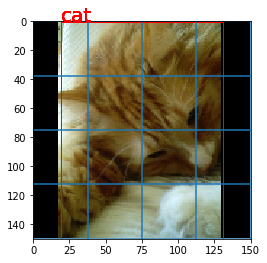

In [55]:
show_boxes_offsets(np.squeeze((img + 1.0)/2), np.squeeze(y))

### Transfer Learning, Detection model
We want to reuse the model we trained for classification, since we know it can also localize the objects in the scene (we saw the saliency maps work).

One way to do so is known as "Transfer Learning", which means we take a model trained on a different dataset for a different problem and transfer it to our problem.

Since the former model is already trained, we can "freeze" the layers already trained and only focus on any new layers we are going to add. This is easily done in Keras by `l.trainable = False` where `l` is a Keras layer.

To build our detection model, we take the classification model and snip off the head (classification parts, e.g. Dense, Flatten, etc.), basically take it up to `.layers[-4]`, and connect new layers that will do what we need according to our new problem.

Working with the bounding box grid we set up, we add for each of the 14 bounding boxes:
1. A Dense layer to regress the BBox offset (4 output params with 'linear' activation)
1. A Dense layer to predict the class (1 output param with 'sigmoid' activation)
1. A Dense layer to predict whether the BBox has a object in it (1 output param with 'sigmoid' activation)

Finally we must `Concatenate()` all the outputs to a single output vector of 84 outputs. This vector we will meet again when we design the loss function.

In [56]:
def make_detection_model():
    classification_model = make_classification_model()
    classification_model.load_weights('cats_vs_dogs.best_weights.hdf5')
    
    # TODO: set `l.trainable = False` for all the layers in `classification_model.layers`
    for l in classification_model.layers:
        l.trainable = False

    feature_layer = classification_model.layers[-4].output
    x = Conv2D(32, (1,1))(feature_layer) # a 1x1 conv to reduce filter depth from 192 to 32
    gathered = Flatten()(x)
    
    concat = []
    for i in range(len(bb_box_grid)):
        # TODO: for each box add: 
        # 1. Dense(4) with `linear` activation for x1,y1,x2,y2 offset regression
        l1 =Dense(4, activation='linear')(gathered)
        # 2. Dense(1) with `sigmoid` activation for class
        l2=Dense(1, activation='sigmoid')(gathered)
        # 3. Dense(1) with `sigmoid` activation for objectness
        l3=Dense(1, activation='sigmoid')(gathered)
        # finally, add all the layers to the concatenation: `concat += [...]`
        concat+=[l1,l2,l3]

    x = Concatenate()(concat)
    
    return Model(inputs=classification_model.inputs, outputs=x)

In [57]:
detection_model = make_detection_model()

You may want to inspect the model's architecture with `detection_model.summary()`.

One thing to notice is the number of weights for training. More weights, i.e. a bigger network, are harder to traing while controlling overfitting. 

#### Custom Multi-task Loss Function
We are trying to detect and classify at once, these are different tasks.

By detection we mean "regression of bounding box" that calls for a regressiong loss e.g. MSE. In classification we usually use some cross entropy loss, e.g. the binary cross entropy or softmax.

A "multi-task loss" is a loss function that mixes a few problems together.

Remember our output is $84=14\times6$ numbers: [x1_offset, y1_offset, x2_offset, y2_offset, class, is_object] for each bounding box.

For the first 4 numbers we want to use `tf.keras.losses.mean_squared_error`, and for the 5th and 6th numbers (each) we'd want to use `tf.keras.losses.binary_crossentropy`.

In [59]:
def detection_loss(y_true, y_pred):
    total_loss = 0
    for i in range(0,6*14,6):
        #TODO: add the losses for the 6 numbers from y_true and y_pred
        # e.g. total_loss += tf.keras.losses.mean_squared_error(...) + ...
        total_loss += tf.keras.losses.mean_squared_error(y_true[:,i],y_pred[:,i])
        total_loss += tf.keras.losses.mean_squared_error(y_true[:,i+1],y_pred[:,i+1])
        total_loss += tf.keras.losses.mean_squared_error(y_true[:,i+2],y_pred[:,i+2])
        total_loss += tf.keras.losses.mean_squared_error(y_true[:,i+3],y_pred[:,i+3])
        total_loss += tf.keras.losses.binary_crossentropy(y_true[:,i+4],y_pred[:,i+4])
        total_loss += tf.keras.losses.binary_crossentropy(y_true[:,i+5],y_pred[:,i+5])
    
    return total_loss

Note that YOLO [[Redmon 2016]](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Redmon_You_Only_Look_CVPR_2016_paper.pdf) is using a slightly different loss. They have SSD (sum of squared differences) on the top-left X, Y of the rectangle and SSD of the square roots of the W, H of the rectangle, e.g. 
$$
\displaystyle\left(\sqrt{W_\mathrm{True}}-\sqrt{W_\mathrm{Pred}}\right)^2+\left(\sqrt{H_\mathrm{True}}-\sqrt{H_\mathrm{Pred}}\right)^2
$$
Also, surprisingly they are not using a binary cross-entropy for the class score or the objectness probability, instead they are again using SSD with complement for punishing False-Positives: $\mathcal{1}_{\mathrm{obj}}\left(C_\mathrm{True}-C_\mathrm{Pred}\right)^2+\mathcal{1}_{\mathrm{not\_obj}}\left(C_\mathrm{True}-C_\mathrm{Pred}\right)^2$

You're welcome to try this scheme, at least for the bounding box. It should be very simple to implement the width root (e.g. `w = K.square(x2-x1)`) and then use it in the `tf.keras.losses.mean_squared_error`.

In [60]:
# TODO: compile your model with `adam` optimizer and the `detection_loss` loss function
detection_model.compile(optimizer='adam', 
                        loss=detection_loss)

In [61]:
checkpoint = ModelCheckpoint('cats_dogs_detection.best_weights.hdf5', 
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='auto')

In [62]:
detection_model.fit(detection_ds_train,
                    epochs=40,
                    steps_per_epoch=2500//32,
                    validation_data=detection_ds_val,
                    validation_steps=50,
                    callbacks=[checkpoint]
                    )

Epoch 1/40
78/78 [==============================] - 87s 1s/step - loss: 226.7151 - val_loss: 98.8808
Epoch 2/40
78/78 [==============================] - 57s 729ms/step - loss: 89.3927 - val_loss: 56.9763
Epoch 3/40
78/78 [==============================] - 57s 724ms/step - loss: 57.7460 - val_loss: 42.8416
Epoch 4/40
78/78 [==============================] - 61s 787ms/step - loss: 41.9343 - val_loss: 32.5911
Epoch 5/40
78/78 [==============================] - 56s 716ms/step - loss: 32.5620 - val_loss: 26.3419
Epoch 6/40
78/78 [==============================] - 64s 822ms/step - loss: 26.5106 - val_loss: 23.8269
Epoch 7/40
78/78 [==============================] - 56s 714ms/step - loss: 22.6763 - val_loss: 20.2576
Epoch 8/40
78/78 [==============================] - 56s 721ms/step - loss: 20.0987 - val_loss: 22.6703
Epoch 9/40
78/78 [==============================] - 55s 707ms/step - loss: 18.1732 - val_loss: 18.7012
Epoch 10/40
78/78 [==============================] - 54s 694ms/step - loss:

### Qualitatively evaluate the model

In [63]:
detection_model.load_weights('cats_dogs_detection.best_weights.hdf5')

In [64]:
next_el = it.get_next()

In [65]:
K.get_session().run(next_el) # this is an image of a bike

(array([[[[-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          ...,
          [-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.]],
 
         [[-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          ...,
          [-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.]],
 
         [[-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          ...,
          [-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.]],
 
         ...,
 
         [[-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          ...,
          [-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.]],
 
         [[-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.],
          ...,
          [-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.]],
 
         [[-1., -1., -1.],
          [-1., -1., -1.],
          [-1., -1., -1.],
   

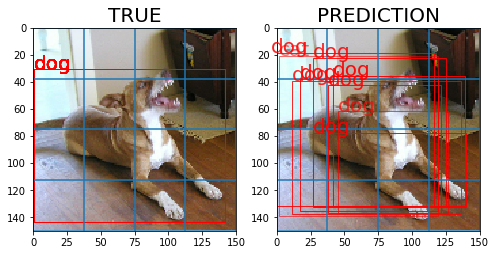

In [66]:
img,y = K.get_session().run(next_el)
y_pred = detection_model.predict(img)
plt.figure(figsize=(8,4))
plt.subplot(121),plt.title('TRUE', fontsize=20)
show_boxes_offsets(np.squeeze((img + 1.0)/2), np.squeeze(y))
plt.subplot(122),plt.title('PREDICTION', fontsize=20)
show_boxes_offsets(np.squeeze((img + 1.0)/2), np.squeeze(y_pred))

Time the prediction operation:

In [67]:
%timeit y_pred = detection_model.predict(img)

16.2 ms ± 577 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Neat! You created an object detector! 

It's quite an efficient one too... just 7ms (on NVidia K80) prediction step, that's 140 frames-per-second (FPS)!

Granted, your model can only find cats and dogs, and is restricted to just 14 base BBoxes (with added regression to predict the true box).

Still - I'd say this is a pretty cool thing you made.

## Fine tuning the pretrained layers

Let's see if we can improve further if we unfreeze the pretrained layers.

In [68]:
# TODO: set `.trainable = True` to all layers of the detection model
for l in detection_model.layers:
    l.trainable=True 

In [69]:
# TODO: compile your model with `adam` optimizer and the `detection_loss` loss function
detection_model.compile(optimizer='adam', 
                        loss=detection_loss)

In [70]:
checkpoint = ModelCheckpoint('cats_dogs_detection.unfrozen.best_weights.hdf5', 
                             monitor='val_loss', 
                             verbose=0, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='auto')

In [71]:
detection_model.fit(detection_ds_train,
                    epochs=20,
                    steps_per_epoch=2500//32,
                    validation_data=detection_ds_val,
                    validation_steps=50,
                    callbacks=[checkpoint]
                    )

Epoch 1/20
78/78 [==============================] - 164s 2s/step - loss: 11.8058 - val_loss: 13.0982
Epoch 2/20
78/78 [==============================] - 136s 2s/step - loss: 8.3148 - val_loss: 7.1511
Epoch 3/20
78/78 [==============================] - 136s 2s/step - loss: 5.8943 - val_loss: 5.3449
Epoch 4/20
78/78 [==============================] - 137s 2s/step - loss: 4.8714 - val_loss: 4.2701
Epoch 5/20
78/78 [==============================] - 148s 2s/step - loss: 3.8078 - val_loss: 3.5792
Epoch 6/20
78/78 [==============================] - 152s 2s/step - loss: 3.3408 - val_loss: 3.0788
Epoch 7/20
78/78 [==============================] - 134s 2s/step - loss: 2.8225 - val_loss: 2.6410
Epoch 8/20
78/78 [==============================] - 135s 2s/step - loss: 2.6632 - val_loss: 2.2189
Epoch 9/20
78/78 [==============================] - 152s 2s/step - loss: 2.9931 - val_loss: 2.8156
Epoch 10/20
78/78 [==============================] - 148s 2s/step - loss: 2.6794 - val_loss: 2.7266
Epoch 1

Looks like we can do *much* better! Now the loss is a lot closer to 0 and it seems there's no overfitting.

In [72]:
# load weights from the best run
detection_model.load_weights('cats_dogs_detection.unfrozen.best_weights.hdf5')

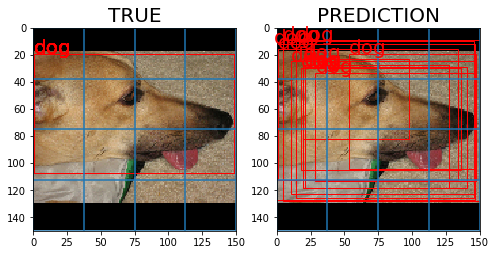

In [73]:
img,y = K.get_session().run(next_el)
y_pred = detection_model.predict(img)
plt.figure(figsize=(8,4))
plt.subplot(121),plt.title('TRUE', fontsize=20)
show_boxes_offsets(np.squeeze((img + 1.0)/2), np.squeeze(y))
plt.subplot(122),plt.title('PREDICTION', fontsize=20)
show_boxes_offsets(np.squeeze((img + 1.0)/2), np.squeeze(y_pred))

Since we have a lot of predicted boxes we need to pool them to a single detection:

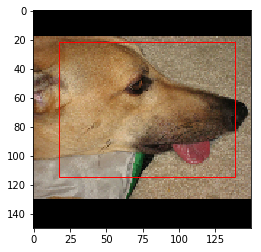

In [74]:
# run this to get the pooled (mean) result
plt.imshow(np.squeeze((img + 1.0)/2))
pred_bbs = []
for i,b in enumerate(y_pred.reshape(len(bb_box_grid),6)):
    if b[-1] < 0.4:
        continue
    pred_bbs += [bb_box_grid[i] - (b[:4] * 150)]
pred_bb = np.mean(pred_bbs, axis=0)
ax = plt.gca()
rect = patches.Rectangle((pred_bb[0],pred_bb[1]),pred_bb[2]-pred_bb[0],pred_bb[3]-pred_bb[1],
                         linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect);

Does it look close to the ground truth?

That's a wrap!